In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helper_fun import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Import Train/Test Data 

In [4]:
import pickle

# Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']


## Logistic Regression

We begin by using logistic regression as our baseline model, a relatively simple binary classifier. If this performs poorly, it suggests that our dataset contains complex, non linear patterns that may require more advanced modelling techniques. Whereas, strong performance would indicate the presence of linear relationships that logistic regression can capture effectively. Ultimately, this baseline evaluation helps us gain insight into the data structure, helping us select models that are likely to outperform the baseline.

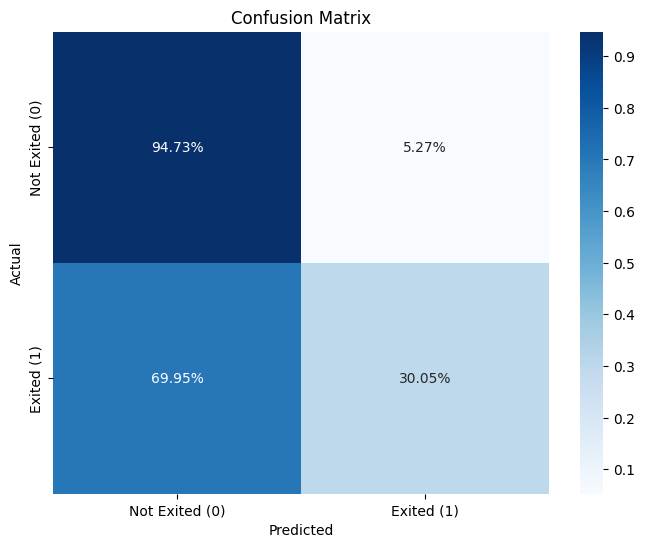

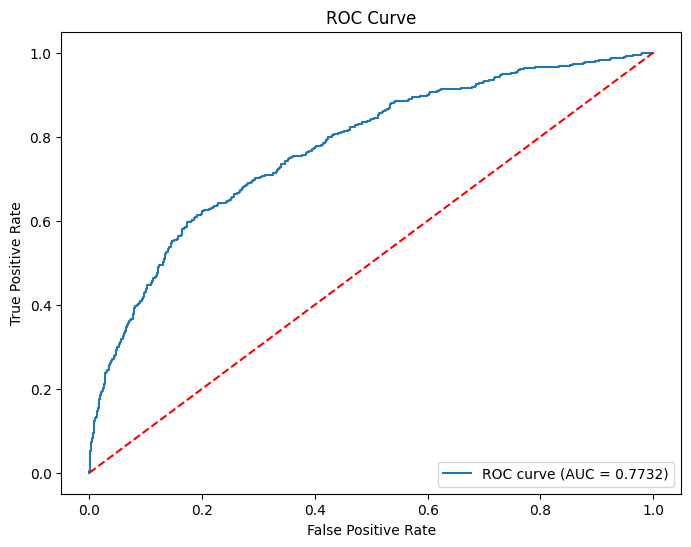

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

import matplotlib.pyplot as plt

performance = {}

# Create a logistic regressor with random state 42
log_reg = LogisticRegression(random_state=42)

# Train the model on the training data
log_reg.fit(X_train_raw, y_train_raw)

# Predict on the test set
y_test_pred = log_reg.predict(X_test_raw)
y_test_pred_prob = log_reg.predict_proba(X_test_raw)[:, 1]

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Exited (0)', 'Exited (1)'],
            yticklabels=['Not Exited (0)', 'Exited (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)

# Generate classification report
report = classification_report(y_test_raw, y_test_pred)
# Extract metrics from classification report
report_dict = classification_report(y_test_raw, y_test_pred, output_dict=True)
balanced_MCC = balanced_MCC_macro_avg(y_test_raw, y_test_pred)

performance = {
                'recall' : report_dict['1']['recall'],
                'f1-score' : report_dict['1']['f1-score'],
                'balalanced_MCC' : balanced_MCC
            }

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [7]:
# Convert the performance dictionary into a DataFrame
performance_df = pd.DataFrame(performance, index=['Raw split'])
performance_df

,recall,f1-score,balalanced_MCC
Raw split,0.300493,0.398693,0.324913


### Analysis 
The issue with this model is its extremely high false negative rate, where it fails to identify nearly 70% of customers who exited. This low recall on the exited class makes it poorly suited for the bank’s needs, given the high cost implications associated with losing customers without having insights into why they leave. The poor performance suggests that customer exit patterns are likely non linear and influenced by complex multi-feature relationships. Therefore, we propose exploring ensemble methods (Random Forest, Gradient Boosting, KNN and Neural Networks) to capture these underlying patterns.

To assess overall performance more effectively, we use the Balanced MCC which takes into acoount the imbalanced nature and asseses the model’s ability to classify both exited and non-exited customers accurately. The goal is to maximize recall on the exited class (to identify and retain potential churners) while maintaining Balanced MCC score, ensuring reliable performance across both classes.